# Assignment 2, Exercise 1, Classification

## Import Libraries

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score


## Implementations

In [88]:
def read_infections_data():
    """Read in the csv data into a dataframe and perform the correct conversion of associated categorical values, and their data-types as well."""
    infections_data = pd.read_csv("Pneumonia Infections.csv")
    infections_data.columns = [c.replace(' ', '_') for c in infections_data.columns]
    
    # gender mapping
    infections_data['Gender'] = infections_data['Gender'].map({'Other': 0, 'Female': 1, 'Male': 2})
    infections_data['Gender'] = pd.to_numeric(infections_data['Gender'])
    
    # smoker mapping
    infections_data['Smoker'] = infections_data['Smoker'].map({'No': 0, 'Yes': 1})
    infections_data['Smoker'] = pd.to_numeric(infections_data['Smoker'])

    # pnumonia_diagnosed mapping
    infections_data['Pneumonia_diagnosed'] = infections_data['Pneumonia_diagnosed'].map({'No': 0, 'Yes': 1})
    infections_data['Pneumonia_diagnosed'] = pd.to_numeric(infections_data['Pneumonia_diagnosed'])

    return infections_data

In [89]:
def remove_erronous_observations(infections_data):
    """Write a function that excludes erronous observations."""
    infections_data_cleaned = infections_data.dropna().reset_index(drop=True)
    return infections_data_cleaned

In [90]:
def remove_redundant_features(infections_data, corr_threshold=0.8):
    """Write a function that excludes redundant input features that have no effect or are highly correlated with other feautres."""
    
    # remove identifer
    infections_data = infections_data.drop(columns=['Paitent_#'])
    
    corr_matrix = infections_data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    infections_data = infections_data.drop(columns=to_drop)
    
    # plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix")
    plt.show()
    
    return infections_data

In [91]:
def standardize_and_categorize_features(infections_data):
    """Write a function that standardizes numerical features and performs one-hot encoding on categorical features"""
    
    cat_cols = infections_data.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = infections_data.select_dtypes(include=['float64', 'int64']).drop(columns=['Pneumonia_diagnosed']).columns.tolist()

    # for numerical columns
    scaler = StandardScaler()
    infections_data[num_cols] = scaler.fit_transform(infections_data[num_cols])

    # for categorical features
    infections_data = pd.get_dummies(infections_data, columns=cat_cols, drop_first=True)
    
    return infections_data

In [92]:
def split_train_test(infections_data, seed=2):
    return train_test_split(infections_data.drop(columns=['Pneumonia_diagnosed']), infections_data['Pneumonia_diagnosed'], test_size=0.25, random_state=seed)



In [93]:
def train_LR(X_train, y_train, cv_folds=5):
    # We set cv_folds to 5 by default, since it is recommended for a dataset of this size
    parameters = {
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], # Reg strength
        'penalty': ['l1', 'l2'] # Reg type
    }

    # Since it is most important to avoid false negatives in this case, we will use recall as the scoring metric
    grid = GridSearchCV(estimator=LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced'), param_grid=parameters, cv=cv_folds, scoring='recall')
    grid.fit(X_train, y_train)

    return grid.best_estimator_, grid.best_params_, grid


In [94]:
def train_DT(X_train, y_train, cv_folds=5, seed=2):
    # We set cv_folds to 5 by default, since it is recommended for a dataset of this size
    parameters = {
        'max_depth': [3, 5, 10, 20, None], # We use max_depth to control overfitting
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    }

    # Since it is most important to avoid false negatives in this case, we will use recall as the scoring metric
    grid = GridSearchCV(estimator=DecisionTreeClassifier(random_state=seed, class_weight='balanced'), param_grid=parameters, cv=cv_folds, scoring='recall')
    grid.fit(X_train, y_train)

    return grid.best_estimator_, grid.best_params_, grid

In [95]:
def train_LR_best_params(X_train, y_train, best_params, seed=2):
    solver = 'liblinear' if best_params.get('penalty') == 'l1' else 'lbfgs'

    model = LogisticRegression(**best_params, max_iter=1000, random_state=seed, class_weight='balanced', solver=solver)
    model.fit(X_train, y_train)
    return model

In [96]:
def train_DT_best_params(X_train, y_train, best_params, seed=2):
    model = DecisionTreeClassifier(**best_params, random_state=seed, class_weight='balanced')
    model.fit(X_train, y_train)
    return model

In [97]:
def predict_evaluate(model_lr, model_dt, X_test, y_test):
    results = {}
    for name, model in [('Logistic Regression', model_lr), ('Decision Tree', model_dt)]:
        y_pred = model.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)

        results[name] = {
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy
        }
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    return results

Raw data preview:


,Paitent_#,Age,Weight,Gender,Smoker,Income,Insurance_Coverage,Exercise_freqeuncy,Previous_Hosptalizations,Heart_Rate,Pneumonia_diagnosed
0,1,58.0,88,1,1,90000.0,2213.0,1,3.0,106,0.0
1,2,58.0,98,1,0,31000.0,1448.0,5,0.0,83,0.0
2,3,39.0,99,1,0,33000.0,546.0,1,2.0,87,0.0
3,4,19.0,52,1,0,95000.0,575.0,4,1.0,83,0.0
4,5,75.0,77,1,0,57000.0,1879.0,1,6.0,104,0.0


After removing erroneous observations:


,Paitent_#,Age,Weight,Gender,Smoker,Income,Insurance_Coverage,Exercise_freqeuncy,Previous_Hosptalizations,Heart_Rate,Pneumonia_diagnosed
0,1,58.0,88,1,1,90000.0,2213.0,1,3.0,106,0.0
1,2,58.0,98,1,0,31000.0,1448.0,5,0.0,83,0.0
2,3,39.0,99,1,0,33000.0,546.0,1,2.0,87,0.0
3,4,19.0,52,1,0,95000.0,575.0,4,1.0,83,0.0
4,5,75.0,77,1,0,57000.0,1879.0,1,6.0,104,0.0


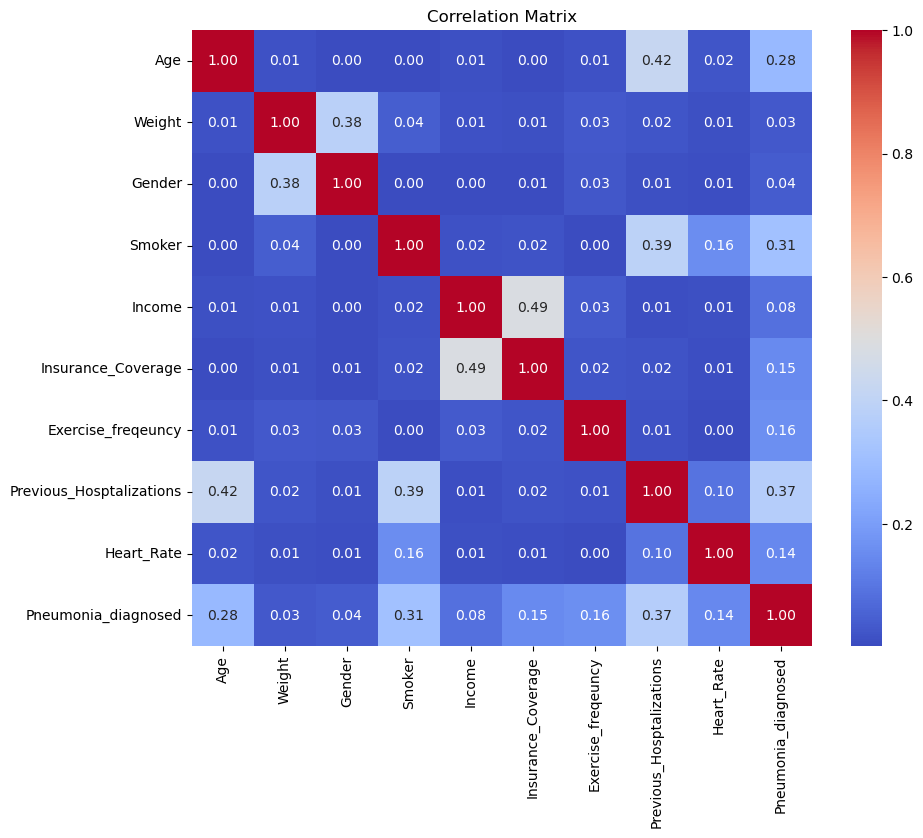

After removing redundant features:


,Age,Weight,Gender,Smoker,Income,Insurance_Coverage,Exercise_freqeuncy,Previous_Hosptalizations,Heart_Rate,Pneumonia_diagnosed
0,58.0,88,1,1,90000.0,2213.0,1,3.0,106,0.0
1,58.0,98,1,0,31000.0,1448.0,5,0.0,83,0.0
2,39.0,99,1,0,33000.0,546.0,1,2.0,87,0.0
3,19.0,52,1,0,95000.0,575.0,4,1.0,83,0.0
4,75.0,77,1,0,57000.0,1879.0,1,6.0,104,0.0


After standardizing and categorizing features:


,Age,Weight,Gender,Smoker,Income,Insurance_Coverage,Exercise_freqeuncy,Previous_Hosptalizations,Heart_Rate,Pneumonia_diagnosed
0,0.668324,0.195164,-0.592644,2.026809,1.244912,0.789046,-1.383068,0.174535,0.877208,0.0
1,0.668324,0.739934,-0.592644,-0.493386,-1.467703,-0.187471,1.425768,-1.063116,-1.132026,0.0
2,-0.456665,0.794411,-0.592644,-0.493386,-1.375750,-1.338868,-1.383068,-0.238016,-0.782594,0.0
3,-1.640865,-1.766010,-0.592644,-0.493386,1.474795,-1.301849,0.723559,-0.650566,-1.132026,0.0
4,1.674893,-0.404083,-0.592644,-0.493386,-0.272313,0.362697,-1.383068,1.412185,0.702492,0.0


Total number of pneumonia cases: 779.0
Total number of non-pneumonia cases: 1918.0
Training and testing sets created.
X_train shape: (2022, 9)
X_test shape: (675, 9)
y_train shape: (2022,)
y_test shape: (675,)
Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l1'}
Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}


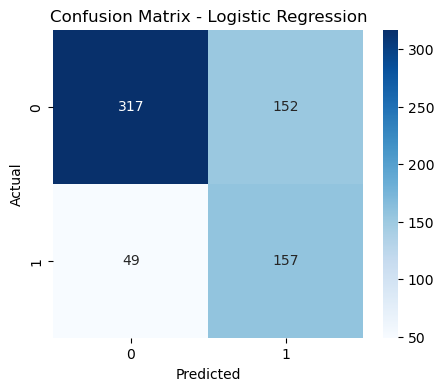

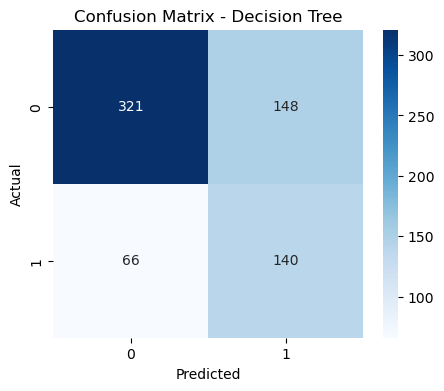

Logistic Regression:
 Precision: 0.5080906148867314
 Recall: 0.7621359223300971
 Accuracy: 0.7022222222222222
Decision Tree:
 Precision: 0.4861111111111111
 Recall: 0.6796116504854369
 Accuracy: 0.682962962962963


In [98]:
df = read_infections_data()
print("Raw data preview:")
display(df.head())

df = remove_erronous_observations(df)
print("After removing erroneous observations:")
display(df.head())

df = remove_redundant_features(df)
print("After removing redundant features:")
display(df.head())

df = standardize_and_categorize_features(df)
print("After standardizing and categorizing features:")
display(df.head())


# amount of pneumonia cases
print("Total number of pneumonia cases:", df['Pneumonia_diagnosed'].sum())
print("Total number of non-pneumonia cases:", len(df) - df['Pneumonia_diagnosed'].sum())

X_train, X_test, y_train, y_test = split_train_test(df)
print("Training and testing sets created.")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

model_lr, best_params_lr, grid_lr = train_LR(X_train, y_train)
print("Best parameters for Logistic Regression:", best_params_lr)

model_dt, best_params_dt, grid_dt = train_DT(X_train, y_train)
print("Best parameters for Decision Tree:", best_params_dt)

model_lr_best = train_LR_best_params(X_train, y_train, best_params_lr)
model_dt_best = train_DT_best_params(X_train, y_train, best_params_dt)

results = predict_evaluate(model_lr_best, model_dt_best, X_test, y_test)
for model_name, metrics in results.items():
    print(model_name + ":")
    print(" Precision: " + str(metrics['Precision']))
    print(" Recall: " + str(metrics['Recall']))
    print(" Accuracy: " + str(metrics['Accuracy']))
plt.show()

### Model Comparison Summary

Logistic Regression performs better overall. It achieves the highest recall (0.76), meaning it detects more pneumonia cases, which is crucial in medical settings. It also slightly outperforms the Decision Tree in precision and accuracy. Therefore, Logistic Regression is the preferred model in this case.

# Assignment 2, Exercise 2, K-means Clustrering


## Export Libraries

## Implementations

In [99]:
# *** Write your code here to do statistical analysis***

In [100]:
# *** Write your code here to normalize the data and transform it to a number array***

In [101]:
# *** Insert your code here to analyze the number of clusters using inertia***

In [102]:
# *** Insert your code here to analyze the number of clusters using Silhouette score***